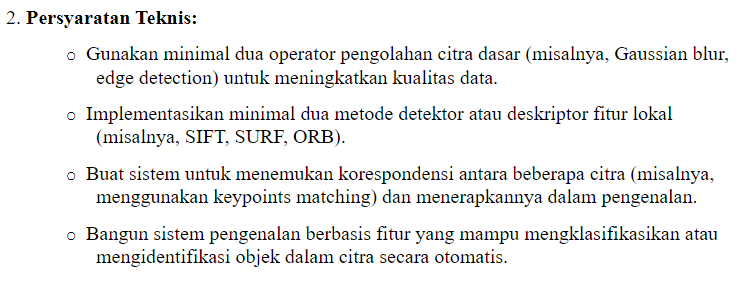

In [46]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import pytesseract

In [47]:
def bgr2rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

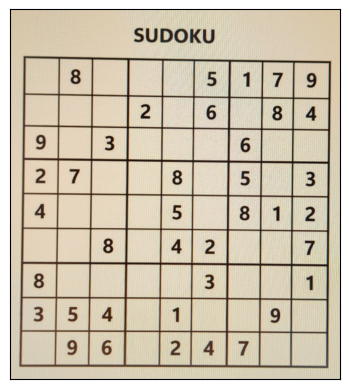

In [48]:
# FILE_PATH ='./dummy_input/Screenshot 2024-12-06 212932.png'
FILE_PATH = './dummy_input/PH_LINK1.jpg'
# FILE_PATH = './dummy_input/sudoku_grid_ex3.jpg'
# FILE_PATH = './dummy_input/wacky grid 3.png'
# FILE_PATH = './dummy_input/wacky grid 2.jpg'
# FILE_PATH = './dummy_input/wacky grid 1.jpg'
image = cv2.imread(FILE_PATH)
# image = cv2.resize(image, (1000, 1000))
plt.imshow(bgr2rgb(image))
plt.xticks([])
plt.yticks([])
plt.show() 

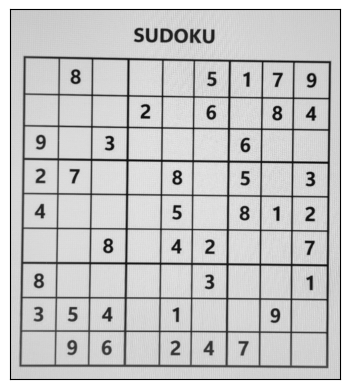

In [49]:
# Grayscale Sudoku Image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

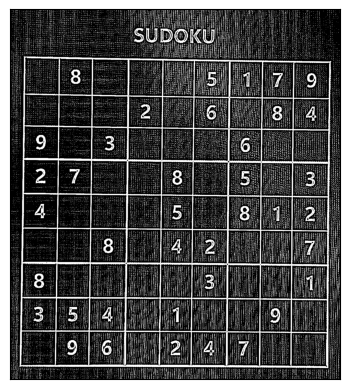

In [50]:
# Blur it and then make it Black n White
blur_gray_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
# thresh_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 7)
thresh_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 7)
# _, thresh_image = cv2.threshold(blur_gray_image, 200, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

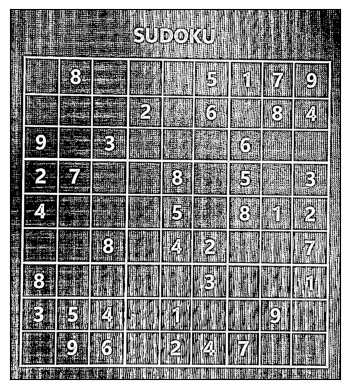

In [51]:
# make the line thicker
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)

dilated_image = cv2.dilate(thresh_image, kernel, iterations=1)
plt.imshow(dilated_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

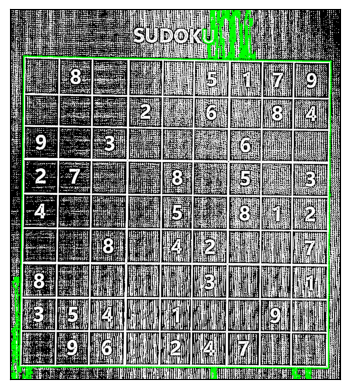

In [52]:
# Locate sudoku
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
largest_contour = max(contours, key=cv2.contourArea)

contour_image = cv2.cvtColor(dilated_image, cv2.COLOR_GRAY2BGR)  
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3)  

plt.imshow(contour_image)
plt.xticks([])
plt.yticks([])
plt.show()

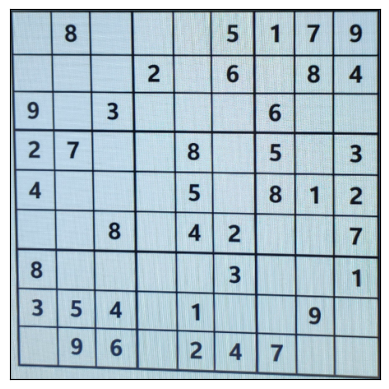

In [53]:
# Fix the perspective of the sudoku
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

pts = approx.reshape(4, 2)

rect = np.zeros((4, 2), dtype="float32")
s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)] 
rect[2] = pts[np.argmax(s)] 
diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)] 
rect[3] = pts[np.argmax(diff)] 

width = 450  
height = 450  
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

M = cv2.getPerspectiveTransform(rect, dst)
warped_image = cv2.warpPerspective(image, M, (width, height))

plt.imshow(warped_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

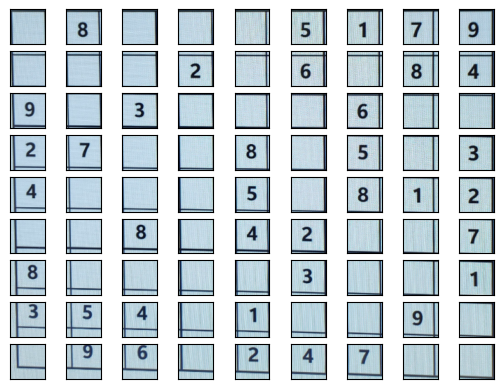

In [54]:
# Split it into 81 image where's each image contain 1 cell from the grid
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = splitBoxes(warped_image)

for i in range(len(boxes)):
    plt.subplot(9, 9, i + 1)
    plt.imshow(boxes[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

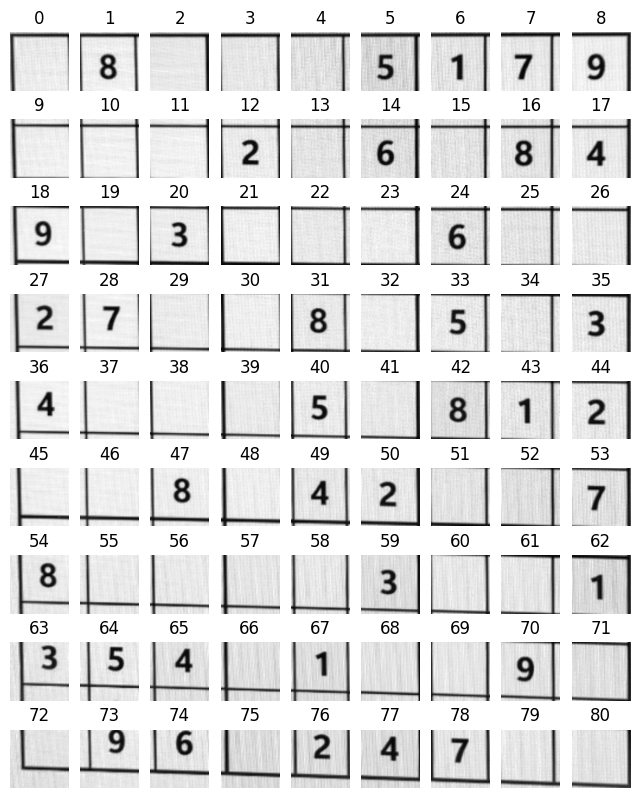

In [55]:
# Preprocess each image in boxes
w, h = 150, 150

processed_boxes = []

for i in range(len(boxes)):
    target_image = boxes[i]
    gray_target = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
    gray_target = cv2.resize(gray_target, (w, h))
    processed_boxes.append(gray_target) 

plt.figure(figsize=(8, 10))
for i in range(len(processed_boxes)):
    plt.subplot(9, 9, i + 1)
    plt.imshow(processed_boxes[i], cmap='gray')  
    plt.title(i)
    plt.axis('off')

plt.show()

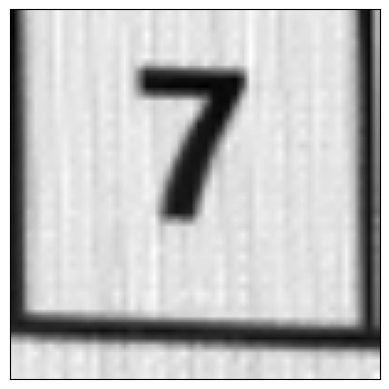

(150, 150)


In [56]:
target_image = processed_boxes[78]

plt.imshow(target_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

print(target_image.shape)


Number detected (black pixels in the center area).


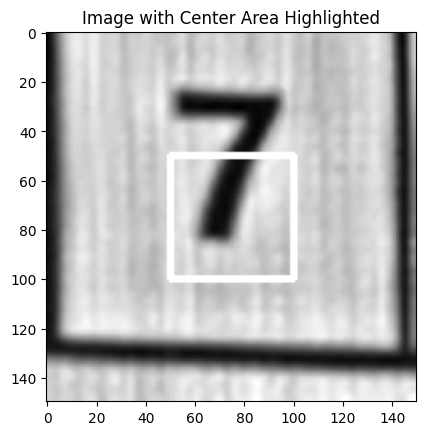

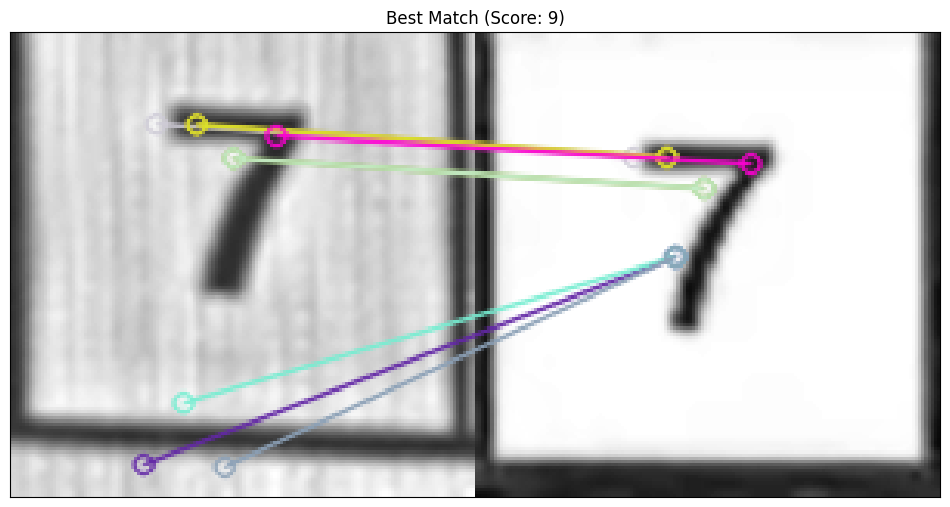

In [57]:
def has_black_pixel(image, center_size=50, threshold=40, pixel_count_threshold=50):
    height, width = image.shape
    center_x, center_y = width // 2, height // 2
    half_size = center_size // 2
    center_area = image[center_y - half_size:center_y + half_size, center_x - half_size:center_x + half_size]
    black_pixels = np.sum(center_area < threshold)
    if black_pixels > pixel_count_threshold:
        return True, center_area
    return False, center_area

# Define file path for dataset
FILE_PATH = './Dataset_150'

# Resize and preprocess target image
target_image = cv2.resize(target_image, (150, 150))
target_image = cv2.GaussianBlur(target_image, (5, 5), 0)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
target_image = clahe.apply(target_image)

# Check if there are black pixels in the center
is_num, center_area = has_black_pixel(target_image, center_size=50, threshold=50, pixel_count_threshold=10)

# Visualize the center area
if is_num:
    print("Number detected (black pixels in the center area).")
else:
    print("Blank image detected (no significant black pixels in the center area).")

# Highlight the area being checked (center region)
height, width = target_image.shape
center_x, center_y = width // 2, height // 2
center_size = 50  # Size of the area to highlight
half_size = center_size // 2

# Draw a rectangle around the center area
image_with_rectangle = target_image.copy()
cv2.rectangle(image_with_rectangle, 
              (center_x - half_size, center_y - half_size), 
              (center_x + half_size, center_y + half_size), 
              (255, 0, 0), 2)  # Red rectangle

# Show the image with the highlighted area
plt.imshow(image_with_rectangle, cmap='gray')
plt.title("Image with Center Area Highlighted")
plt.show()

# Main logic if the image is not blank (i.e., it has a number)
if is_num:
    # Initialize SIFT detector
    sift = cv2.SIFT_create(nfeatures=8000, contrastThreshold=0.03, edgeThreshold=10, sigma=1.6)

    # Detect keypoints and descriptors in target image
    target_keypoints, target_descriptors = sift.detectAndCompute(target_image, None)

    # Initialize BFMatcher for SIFT
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # Tracking best match
    best_match_score = 0
    best_match_data = {}

    # Process dataset images
    for sub in os.listdir(FILE_PATH):
        sub_path = os.path.join(FILE_PATH, sub)
        for image_path in os.listdir(sub_path):
            img_path = os.path.join(sub_path, image_path)

            # Load and preprocess dataset image
            image_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image_data = cv2.resize(image_data, (150, 150))
            image_data = cv2.GaussianBlur(image_data, (5, 5), 0)
            image_data = clahe.apply(image_data)

            # Detect keypoints and descriptors in dataset image
            img_keypoints, img_descriptors = sift.detectAndCompute(image_data, None)
            
            if img_descriptors is None:
                continue

            # Match descriptors using BFMatcher
            matches = bf.knnMatch(target_descriptors, img_descriptors, k=2)

            # Lowe's ratio test
            good_matches = [m for m, n in matches if m.distance < 0.6 * n.distance]

            # Filter matches using RANSAC
            if len(good_matches) >= 8:
                src_pts = np.float32([target_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([img_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                good_matches = [good_matches[i] for i in range(len(mask)) if mask[i]]

            # Update best match
            current_match_score = len(good_matches)
            if current_match_score > best_match_score:
                best_match_score = current_match_score
                best_match_data = {
                    'image_data': image_data,
                    'keypoints': img_keypoints,
                    'matches': good_matches
                }

    # Visualize result
    if best_match_data:
        result_image = cv2.drawMatches(
            target_image,
            target_keypoints,
            best_match_data['image_data'],
            best_match_data['keypoints'],
            best_match_data['matches'],
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        plt.figure(figsize=(12, 8))
        plt.imshow(result_image)
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.title(f"Best Match (Score: {best_match_score})")
        plt.show()

    else:
        print("No suitable match found!")
else:
    print("Blank image detected")

In [58]:
def has_black_pixel(image, center_size=50, threshold=40, pixel_count_threshold=50):
    height, width = image.shape
    center_x, center_y = width // 2, height // 2
    half_size = center_size // 2
    center_area = image[center_y - half_size:center_y + half_size, center_x - half_size:center_x + half_size]
    black_pixels = np.sum(center_area < threshold)
    if black_pixels > pixel_count_threshold:
        return True
    return False

sift = cv2.SIFT_create(nfeatures=5000, contrastThreshold=0.04, edgeThreshold=10)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
result_matrix = np.zeros((9, 9), dtype=int)

for i, target_image in enumerate(processed_boxes):
    row = i // 9
    col = i % 9

    target_image = cv2.resize(target_image, (150, 150))
    target_image = cv2.GaussianBlur(target_image, (5, 5), 0) 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    target_image = clahe.apply(target_image)
    
    is_num = has_black_pixel(target_image, center_size=50, threshold=50, pixel_count_threshold=10)
    
    if not is_num:
        print(f"index {i} Skipped")
        result_matrix[row, col] = 0
        continue
    
    target_keypoints, target_descriptors = sift.detectAndCompute(target_image, None)
    
    if target_descriptors is None:
        result_matrix[row, col] = 0
        continue 

    best_match_score = 0
    best_match_label = None

    for sub in os.listdir(FILE_PATH):
        sub_path = os.path.join(FILE_PATH, sub)
        for image_path in os.listdir(sub_path):
            img_path = os.path.join(sub_path, image_path)

            image_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image_data = cv2.resize(image_data, (150, 150))
            image_data = cv2.GaussianBlur(image_data, (5, 5), 0)
            image_data = clahe.apply(image_data)

            img_keypoints, img_descriptors = sift.detectAndCompute(image_data, None)
            
            if img_descriptors is None:
                continue

            matches = bf.knnMatch(target_descriptors, img_descriptors, k=2)

            good_matches = [m for m, n in matches if m.distance < 0.6 * n.distance]

            if len(good_matches) >= 8:
                src_pts = np.float32([target_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([img_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                good_matches = [good_matches[i] for i in range(len(mask)) if mask[i]]

            current_match_score = len(good_matches)
            if current_match_score > best_match_score:
                best_match_score = current_match_score
                best_match_label = sub  

    if best_match_score > 0:
        result_matrix[row, col] = int(best_match_label)
    else:
        result_matrix[row, col] = 0

print("\nResult Matrix:")
print(result_matrix)

index 0 Skipped
index 2 Skipped
index 3 Skipped
index 4 Skipped
index 9 Skipped
index 10 Skipped
index 11 Skipped
index 13 Skipped
index 15 Skipped
index 19 Skipped
index 21 Skipped
index 22 Skipped
index 23 Skipped
index 25 Skipped
index 26 Skipped
index 29 Skipped
index 30 Skipped
index 32 Skipped
index 34 Skipped
index 37 Skipped
index 38 Skipped
index 39 Skipped
index 41 Skipped
index 45 Skipped
index 46 Skipped
index 48 Skipped
index 51 Skipped
index 52 Skipped
index 55 Skipped
index 56 Skipped
index 57 Skipped
index 58 Skipped
index 60 Skipped
index 61 Skipped
index 63 Skipped
index 66 Skipped
index 68 Skipped
index 69 Skipped
index 71 Skipped
index 72 Skipped
index 75 Skipped
index 79 Skipped
index 80 Skipped

Result Matrix:
[[0 8 0 0 0 3 1 7 6]
 [0 0 0 2 0 1 0 8 4]
 [6 0 3 0 0 0 1 0 0]
 [2 7 0 0 8 0 5 0 3]
 [4 0 0 0 5 0 3 1 2]
 [0 0 8 0 4 2 0 0 7]
 [8 0 0 0 0 2 0 0 1]
 [0 3 4 0 4 0 0 6 0]
 [0 4 6 0 2 4 7 0 0]]


In [59]:
sudoku_matrix = result_matrix

def is_valid_move(matrix, row, col, num):
    if num in matrix[row]:
        return False
    if num in matrix[:, col]:
        return False
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    if num in matrix[start_row:start_row + 3, start_col:start_col + 3]:
        return False
    return True

def solve_sudoku(matrix):
    for row in range(9):
        for col in range(9):
            if matrix[row, col] == 0: 
                for num in range(1, 10):  
                    if is_valid_move(matrix, row, col, num):
                        matrix[row, col] = num 
                        if solve_sudoku(matrix):  
                            return True
                        matrix[row, col] = 0  
                return False 
    return True  

original_matrix = sudoku_matrix.copy()

if solve_sudoku(sudoku_matrix):
    print("Sudoku Solved:")
else:
    print("No solution exists")

print("Answer Matrix:")
print(sudoku_matrix)

No solution exists
Answer Matrix:
[[0 8 0 0 0 3 1 7 6]
 [0 0 0 2 0 1 0 8 4]
 [6 0 3 0 0 0 1 0 0]
 [2 7 0 0 8 0 5 0 3]
 [4 0 0 0 5 0 3 1 2]
 [0 0 8 0 4 2 0 0 7]
 [8 0 0 0 0 2 0 0 1]
 [0 3 4 0 4 0 0 6 0]
 [0 4 6 0 2 4 7 0 0]]
